In [48]:
import gensim
import re
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import RandomOverSampler
from imblearn.metrics import classification_report_imbalanced
from nltk.tokenize.regexp import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier, GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, r2_score, mean_squared_error
from tqdm import tqdm
import xgboost
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from matplotlib import pyplot as plt
%matplotlib inline


In [21]:
GOOGLEMODEL = gensim.models.KeyedVectors.load_word2vec_format('../data/GoogleNews-vectors-negative300.bin', binary=True)

GOOGLEMODEL['div'].shape

(300,)

In [22]:
def remove_text_between_tags(text):
    if isinstance(text, list):
        # If 'reviewText' is a list, apply the function to each element of the list
        return [re.sub(r'<.*?>.*?<.*?>', '', item) if isinstance(item, str) else item for item in text]
    elif isinstance(text, str):
        # If 'reviewText' is a string, apply the function directly
        return re.sub(r'<.*?>.*?<.*?>', '', text)
    else:
        return text


In [23]:
df = pd.read_csv('../../../data/processed/full_w2v_df.csv', index_col=0)

df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 602453 entries, 0 to 52452
Columns: 301 entries, 0 to overall
dtypes: float64(300), int64(1)
memory usage: 1.4 GB


,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,overall
0,-0.318359,0.024963,0.176758,0.101501,-0.820892,-0.135696,0.225830,-0.821472,1.262939,0.900177,...,-0.723877,-1.481628,0.516296,-0.310629,-0.918121,0.349976,-0.483765,0.867493,1.792969,4
1,0.339233,0.190918,0.002930,0.466248,0.207031,-0.756538,0.021545,-0.252197,1.321289,0.608032,...,-0.002991,-1.336182,0.439636,-0.260376,-0.344482,-0.257324,-1.484467,-0.675476,0.143860,5
2,-0.083984,0.211182,-0.395508,-0.123047,0.075684,-0.642578,-0.117188,-0.563477,0.718750,0.142822,...,-0.194580,-0.677734,0.284668,-0.110474,-0.082397,-0.073242,-0.542969,0.097656,0.243164,5
3,0.082031,0.706055,-0.333801,0.716797,0.046631,-0.020020,0.170654,0.016113,0.623535,1.138672,...,0.087402,-1.345703,0.159912,0.184570,-0.548828,0.953125,0.926270,0.387329,0.845215,5
4,0.562004,2.063141,0.641327,2.409454,-2.299713,-0.079361,2.213966,-2.263481,0.141418,6.318817,...,0.066101,-1.266113,0.831573,-0.717789,-3.124107,1.606995,-1.510742,-1.568970,1.363419,1


overall
5    416033
4     75439
1     59610
3     30642
2     20729
Name: count, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Index: 602453 entries, 0 to 52452
Columns: 300 entries, 0 to 299
dtypes: float64(300)
memory usage: 1.4 GB
<class 'pandas.core.series.Series'>
Index: 602453 entries, 0 to 52452
Series name: overall
Non-Null Count   Dtype
--------------   -----
602453 non-null  int64
dtypes: int64(1)
memory usage: 9.2 MB


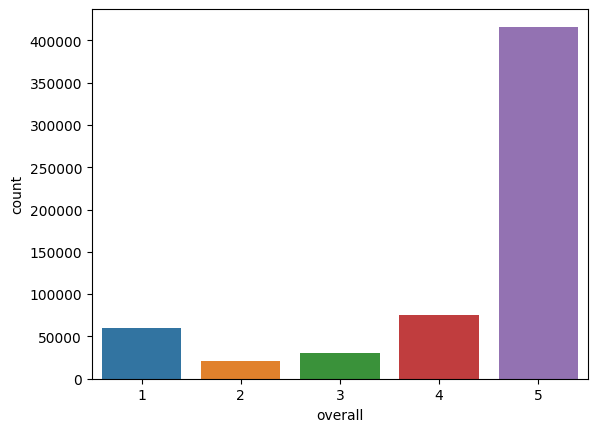

In [24]:
display(df['overall'].value_counts())

warnings.filterwarnings("ignore")

sns.countplot(x='overall', data=df)

warnings.filterwarnings("default")

features = df.drop(columns='overall')
target = df['overall']

features.info()
target.info()

In [25]:
scaler = MinMaxScaler()
feature_W2V = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(feature_W2V, target, test_size=0.25, random_state=69)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(451839, 300)
(451839,)
(150614, 300)
(150614,)


c:\Users\Scratticus\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Scratticus\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Scratticus\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='overall', ylabel='count'>

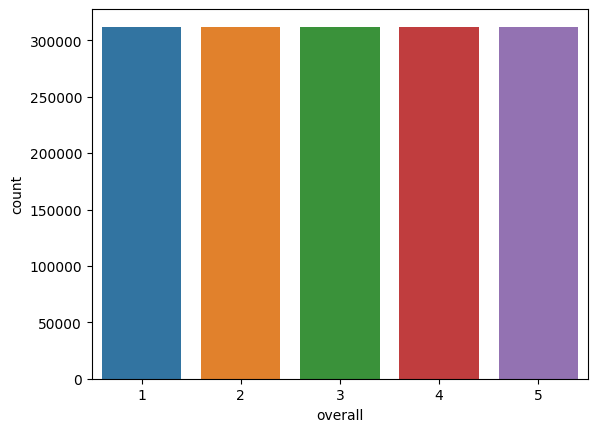

In [26]:
sampler = RandomOverSampler(sampling_strategy='auto')

X_train_sampled, y_train_sampled = sampler.fit_resample(X_train, y_train)

y_train_sampled.value_counts()

sns.countplot(x=y_train_sampled, data=df)


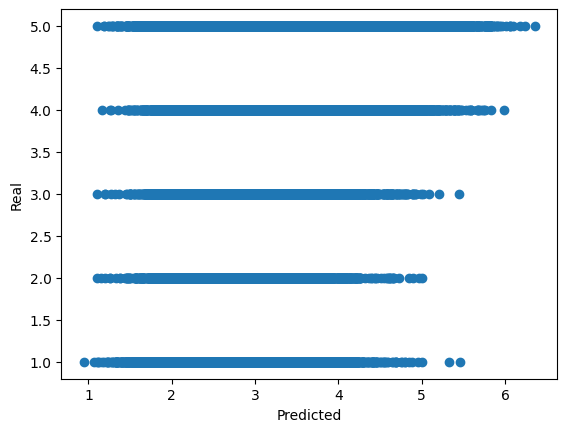

<Figure size 2000x1000 with 0 Axes>

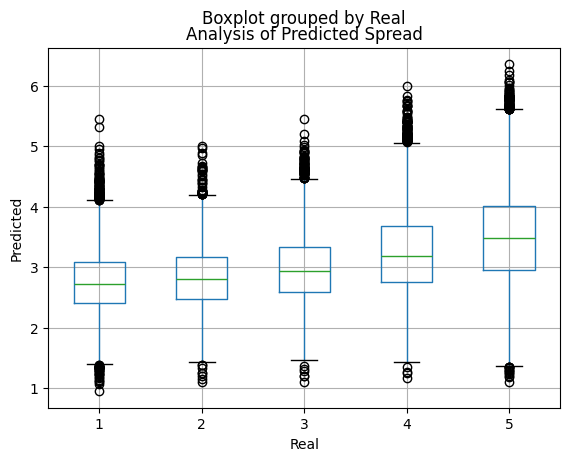

In [27]:
hgbr = HistGradientBoostingRegressor(learning_rate=0.5, max_depth=1000)
hgbr.fit(X_train_sampled, y_train_sampled)
y_pred = hgbr.predict(X_test)

plt.scatter(x=y_pred, y=y_test)
plt.xlabel('Predicted')
plt.ylabel('Real');

pred_data = {
    'Predicted': y_pred,
    'Real': y_test
}

corr_df = pd.DataFrame(pred_data)

corr_df.head()

plt.figure(figsize=(20,10))
corr_df.boxplot(column='Predicted', by='Real')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.title('Analysis of Predicted Spread');

In [37]:
y_pred_cut = pd.cut(x=y_pred, bins=[y_pred.min(),1.5,2.5,3.5,4.5,y_pred.max()], labels=[1,2,3,4,5], include_lowest=True)

orig_acc = accuracy_score(y_test, y_pred_cut)
orig_pre = precision_score(y_test, y_pred_cut, average='weighted')
orig_rec = recall_score(y_test, y_pred_cut, average='weighted')
orig_f1 = f1_score(y_test, y_pred_cut, average='weighted')
orig_r2 = r2_score(y_test, y_pred_cut)
orig_mse = mean_squared_error(y_test, y_pred_cut)

print(f'Final HGBR results:')
print(f'Accuracy: {orig_acc}\nPrecision: {orig_pre}\nRecall: {orig_rec}\nF1 Score {orig_f1}\nR Squared: {orig_r2}\nMSE: {orig_mse}')
print()
print(classification_report_imbalanced(y_test, y_pred_cut))


Final HGBR results:
Accuracy: 0.4386245634535966
Precision: 0.6083552425489055
Recall: 0.4386245634535966
F1 Score 0.4970681552318097
R Squared: -0.9374524721792636
MSE: 3.3062729892307487

                   pre       rec       spe        f1       geo       iba       sup

          1       0.21      0.35      0.85      0.26      0.55      0.28     15072
          2       0.06      0.17      0.90      0.09      0.39      0.14      5193
          3       0.09      0.19      0.90      0.12      0.41      0.16      7635
          4       0.15      0.22      0.82      0.18      0.43      0.17     18712
          5       0.81      0.52      0.73      0.64      0.62      0.37    104002

avg / total       0.61      0.44      0.77      0.50      0.57      0.32    150614



In [57]:
gbc = GradientBoostingClassifier(learning_rate=0.5, max_depth=1000)
gbc.fit(X_train_sampled, y_train_sampled)
y_pred_gbc = gbc.predict(X_test)

plt.scatter(x=y_pred_gbc, y=y_test)
plt.xlabel('Predicted')
plt.ylabel('Real');

KeyboardInterrupt: 

<Figure size 2000x1000 with 0 Axes>

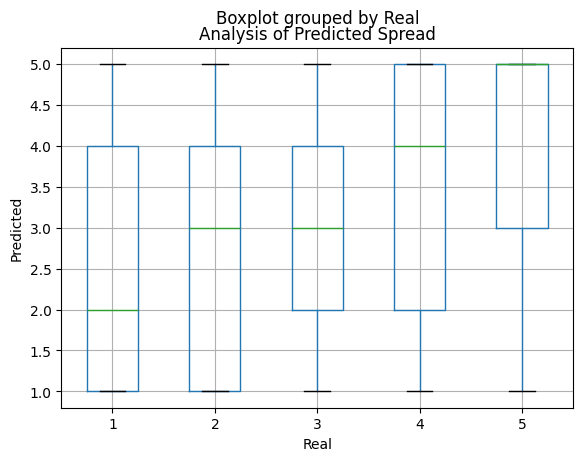

In [ ]:
pred_data = {
    'Predicted': y_pred_gbc,
    'Real': y_test
}

corr_df = pd.DataFrame(pred_data)

corr_df.head()

plt.figure(figsize=(20,10))
corr_df.boxplot(column='Predicted', by='Real')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.title('Analysis of Predicted Spread');

In [ ]:
orig_acc = accuracy_score(y_test, y_pred_gbc)
orig_pre = precision_score(y_test, y_pred_gbc, average='weighted')
orig_rec = recall_score(y_test, y_pred_gbc, average='weighted')
orig_f1 = f1_score(y_test, y_pred_gbc, average='weighted')
orig_r2 = r2_score(y_test, y_pred_gbc)
orig_mse = mean_squared_error(y_test, y_pred_gbc)

print(f'Final GBC results:')
print(f'Accuracy: {orig_acc}\nPrecision: {orig_pre}\nRecall: {orig_rec}\nF1 Score {orig_f1}\nR Squared: {orig_r2}\nMSE: {orig_mse}')
print()
print(classification_report_imbalanced(y_test, y_pred_gbc))


Final HGBC results:
Accuracy: 0.4386245634535966
Precision: 0.6083552425489055
Recall: 0.4386245634535966
F1 Score 0.4970681552318097
R Squared: -0.9374524721792636
MSE: 3.3062729892307487

                   pre       rec       spe        f1       geo       iba       sup

          1       0.21      0.35      0.85      0.26      0.55      0.28     15072
          2       0.06      0.17      0.90      0.09      0.39      0.14      5193
          3       0.09      0.19      0.90      0.12      0.41      0.16      7635
          4       0.15      0.22      0.82      0.18      0.43      0.17     18712
          5       0.81      0.52      0.73      0.64      0.62      0.37    104002

avg / total       0.61      0.44      0.77      0.50      0.57      0.32    150614



Final HGBR results:
Accuracy: 0.6521638094732229
Precision: 0.5462491484050599
Recall: 0.6521638094732229
F1 Score 0.5718929321891172
R Squared: -0.34412173202102614
MSE: 2.293750912929741


<Figure size 2000x1000 with 0 Axes>

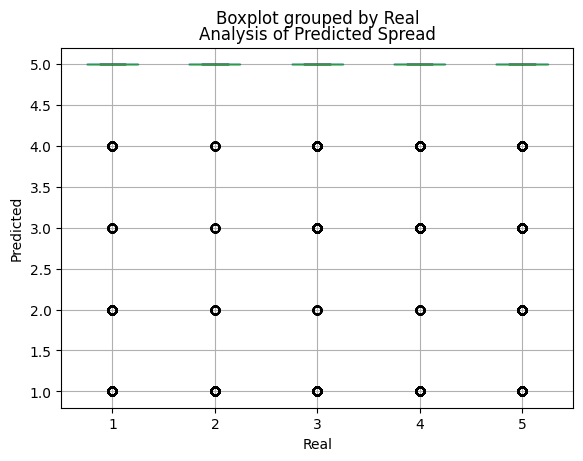

In [32]:
rf_model = RandomForestClassifier(n_jobs=-1)  # You can customize parameters here if needed
rf_model.fit(X_train_sampled, y_train_sampled)
y_pred_train_rf = rf_model.predict(X_train_sampled)
y_pred_test_rf = rf_model.predict(X_test)

pred_data = {
    'Predicted': y_pred_test_rf,
    'Real': y_test
}

corr_df = pd.DataFrame(pred_data)

corr_df.head()

plt.figure(figsize=(20,10))
corr_df.boxplot(column='Predicted', by='Real')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.title('Analysis of Predicted Spread');

In [39]:
orig_acc = accuracy_score(y_test, y_pred_test_rf)
orig_pre = precision_score(y_test, y_pred_test_rf, average='weighted')
orig_rec = recall_score(y_test, y_pred_test_rf, average='weighted')
orig_f1 = f1_score(y_test, y_pred_test_rf, average='weighted')
orig_r2 = r2_score(y_test, y_pred_test_rf)
orig_mse = mean_squared_error(y_test, y_pred_test_rf)

print(f'Final RF results:')
print(f'Accuracy: {orig_acc}\nPrecision: {orig_pre}\nRecall: {orig_rec}\nF1 Score {orig_f1}\nR Squared: {orig_r2}\nMSE: {orig_mse}')
print()
print(classification_report_imbalanced(y_test, y_pred_test_rf))

Final RF results:
Accuracy: 0.6521638094732229
Precision: 0.5462491484050599
Recall: 0.6521638094732229
F1 Score 0.5718929321891172
R Squared: -0.34412173202102614
MSE: 2.293750912929741

                   pre       rec       spe        f1       geo       iba       sup

          1       0.33      0.05      0.99      0.09      0.22      0.05     15072
          2       0.10      0.02      0.99      0.03      0.13      0.01      5193
          3       0.16      0.04      0.99      0.06      0.19      0.03      7635
          4       0.18      0.07      0.95      0.11      0.27      0.06     18712
          5       0.69      0.92      0.09      0.79      0.29      0.09    104002

avg / total       0.55      0.65      0.36      0.57      0.27      0.08    150614



In [33]:
display(pd.crosstab(y_test, y_pred_test_rf, rownames=['Real'], colnames=['Predicted']))

Predicted,1,2,3,4,5
Real,,,,,
1,763,164,94,130,13921
2,186,86,51,62,4808
3,158,59,275,229,6914
4,253,98,249,1392,16720
5,921,491,1006,5875,95709


In [34]:
lr = LinearRegression()

lr.fit(X_train_sampled, y_train_sampled)
y_pred_train_lr = lr.predict(X_train)
y_pred_test_lr = lr.predict(X_test)


Final Linear Reghression results:
Accuracy: 0.05650869109113363
Precision: 0.3923199526648471
Recall: 0.05650869109113363
F1 Score 0.019550827492701088
R Squared: -0.9175282313900812
MSE: 3.2722721659341096


<Figure size 2000x1000 with 0 Axes>

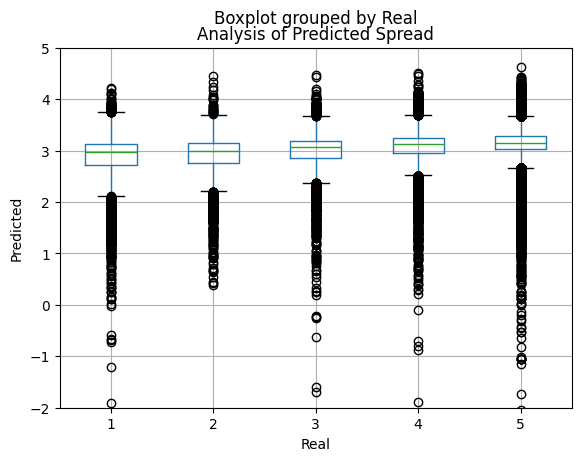

In [35]:
pred_data = {
    'Predicted': y_pred_test_lr,
    'Real': y_test
}

corr_df = pd.DataFrame(pred_data)

corr_df.head()

plt.figure(figsize=(20,10))
corr_df.boxplot(column='Predicted', by='Real')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.ylim(-2, 5)
plt.title('Analysis of Predicted Spread');




In [40]:
y_pred_lr_cut = pd.cut(x=y_pred_test_lr, bins=[y_pred_test_lr.min(),1.5,2.5,3.5,4.5,y_pred_test_lr.max()], labels=[1,2,3,4,5], include_lowest=True)

orig_acc = accuracy_score(y_test, y_pred_lr_cut)
orig_pre = precision_score(y_test, y_pred_lr_cut, average='weighted')
orig_rec = recall_score(y_test, y_pred_lr_cut, average='weighted')
orig_f1 = f1_score(y_test, y_pred_lr_cut, average='weighted')
orig_r2 = r2_score(y_test, y_pred_lr_cut)
orig_mse = mean_squared_error(y_test, y_pred_lr_cut)

print(f'Final Linear Reghression results:')
print(f'Accuracy: {orig_acc}\nPrecision: {orig_pre}\nRecall: {orig_rec}\nF1 Score {orig_f1}\nR Squared: {orig_r2}\nMSE: {orig_mse}')
print()
print(classification_report_imbalanced(y_test, y_pred_lr_cut))

Final Linear Reghression results:
Accuracy: 0.05650869109113363
Precision: 0.3923199526648471
Recall: 0.05650869109113363
F1 Score 0.019550827492701088
R Squared: -0.9175282313900812
MSE: 3.2722721659341096

                   pre       rec       spe        f1       geo       iba       sup

          1       0.27      0.01      1.00      0.02      0.11      0.01     15072
          2       0.08      0.10      0.96      0.09      0.32      0.09      5193
          3       0.05      0.89      0.11      0.10      0.31      0.10      7635
          4       0.12      0.06      0.94      0.08      0.23      0.05     18712
          5       0.50      0.00      1.00      0.00      0.00      0.00    104002

avg / total       0.39      0.06      0.95      0.02      0.07      0.02    150614



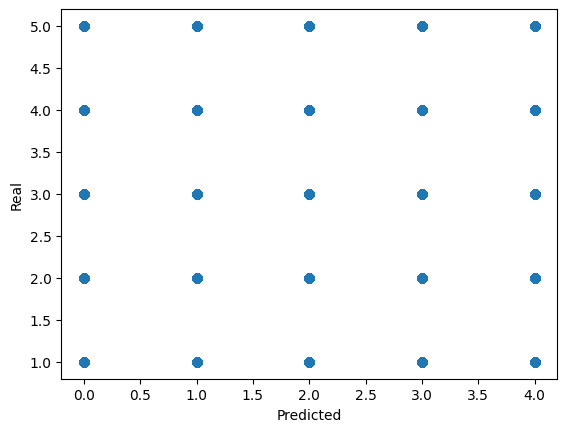

In [49]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_sampled)
y_test_encoded = label_encoder.transform(y_test)

xgb = xgboost.XGBClassifier()
xgb.fit(X_train_sampled, y_train_encoded)
y_pred_xgb = xgb.predict(X_test)

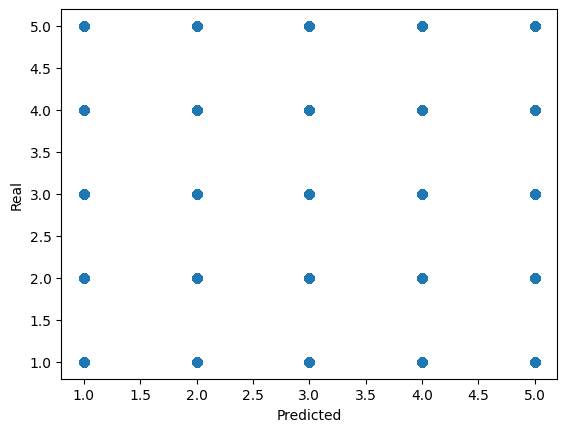

In [54]:
y_pred_xgb += 1

plt.scatter(x=y_pred_xgb, y=y_test)
plt.xlabel('Predicted')
plt.ylabel('Real');

<Figure size 2000x1000 with 0 Axes>

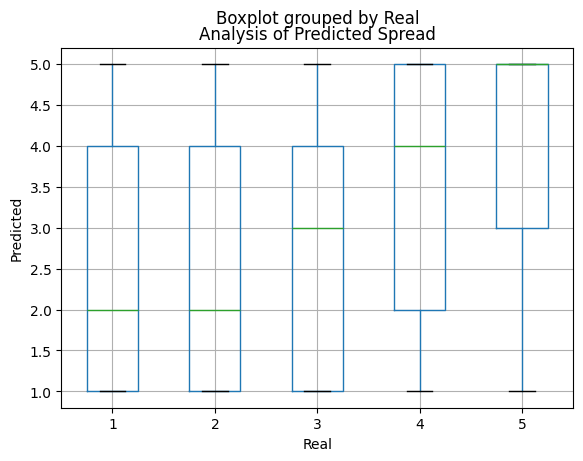

In [55]:
pred_data = {
    'Predicted': y_pred_xgb,
    'Real': y_test
}

corr_df = pd.DataFrame(pred_data)

corr_df.head()

plt.figure(figsize=(20,10))
corr_df.boxplot(column='Predicted', by='Real')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.title('Analysis of Predicted Spread');

In [56]:
orig_acc = accuracy_score(y_test, y_pred_xgb)
orig_pre = precision_score(y_test, y_pred_xgb, average='weighted')
orig_rec = recall_score(y_test, y_pred_xgb, average='weighted')
orig_f1 = f1_score(y_test, y_pred_xgb, average='weighted')
orig_r2 = r2_score(y_test, y_pred_xgb)
orig_mse = mean_squared_error(y_test, y_pred_xgb)

print(f'Final Linear Regression results:')
print(f'Accuracy: {orig_acc}\nPrecision: {orig_pre}\nRecall: {orig_rec}\nF1 Score {orig_f1}\nR Squared: {orig_r2}\nMSE: {orig_mse}')
print()
print(classification_report_imbalanced(y_test, y_pred_xgb))

Final Linear Regression results:
Accuracy: 0.46320395182386764
Precision: 0.6243483681027933
Recall: 0.46320395182386764
F1 Score 0.5187041730673799
R Squared: -0.9056188189597574
MSE: 3.2519486900288155

                   pre       rec       spe        f1       geo       iba       sup

          1       0.23      0.43      0.84      0.30      0.60      0.34     15072
          2       0.06      0.18      0.90      0.09      0.40      0.15      5193
          3       0.09      0.19      0.90      0.12      0.41      0.16      7635
          4       0.17      0.21      0.85      0.19      0.42      0.17     18712
          5       0.83      0.55      0.75      0.66      0.64      0.40    104002

avg / total       0.62      0.46      0.79      0.52      0.59      0.35    150614

